# Working with text: string methods and regular expressions

This notebook is a companion to the Data 100 lecture on text manipulation in Python and Pandas.

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile

## Canonicalization with Basic Python

In [46]:
county_and_state = pd.read_csv('data/county_and_state.csv')
county_and_pop = pd.read_csv('data/county_and_population.csv')

Suppose we'd like to join these two tables. Unfortunately, we can't, because the strings representing the county names don't match, as seen below.

In [47]:
county_and_state

,County,State
0,De Witt County,IL
1,Lac qui Parle County,MN
2,Lewis and Clark County,MT
3,St John the Baptist Parish,LS


In [48]:
county_and_pop

,County,Population
0,DeWitt,16798
1,Lac Qui Parle,8067
2,Lewis & Clark,55716
3,St. John the Baptist,43044


 Before we can join them, we'll do what I call **canonicalization**.

Canonicalization: A process for converting data that has more than one possible representation into a "standard", "normal", or canonical form (definition via Wikipedia).

In [49]:
def canonicalize_county(county_name):
    return (
        county_name
        .lower()               # lower case
        .replace(' ', '')      # remove spaces
        .replace('&', 'and')   # replace &
        .replace('.', '')      # remove dot
        .replace('county', '') # remove county
        .replace('parish', '') # remove parish
    )

In [50]:
county_and_pop['clean_county'] = county_and_pop['County'].map(canonicalize_county)
county_and_state['clean_county'] = county_and_state['County'].map(canonicalize_county)

display(county_and_pop)  # display outputs even if not last line in cell - like a fancy print()
county_and_state

,County,Population,clean_county
0,DeWitt,16798,dewitt
1,Lac Qui Parle,8067,lacquiparle
2,Lewis & Clark,55716,lewisandclark
3,St. John the Baptist,43044,stjohnthebaptist


,County,State,clean_county
0,De Witt County,IL,dewitt
1,Lac qui Parle County,MN,lacquiparle
2,Lewis and Clark County,MT,lewisandclark
3,St John the Baptist Parish,LS,stjohnthebaptist


In [51]:
county_and_pop.merge(county_and_state, on='clean_county')

,County_x,Population,clean_county,County_y,State
0,DeWitt,16798,dewitt,De Witt County,IL
1,Lac Qui Parle,8067,lacquiparle,Lac qui Parle County,MN
2,Lewis & Clark,55716,lewisandclark,Lewis and Clark County,MT
3,St. John the Baptist,43044,stjohnthebaptist,St John the Baptist Parish,LS


## Processing Data from a Text Log Using Basic Python

In [52]:
log_fname = 'data/log.txt'
!cat {log_fname}

169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04/ HTTP/1.1" 200 2585 "http://anson.ucdavis.edu/courses/"
193.205.203.3 - - [2/Feb/2005:17:23:6 -0800] "GET /stat141/Notes/dim.html HTTP/1.0" 404 302 "http://eeyore.ucdavis.edu/stat141/Notes/session.html"
169.237.46.240 - "" [3/Feb/2006:10:18:37 -0800] "GET /stat141/homework/Solutions/hw1Sol.pdf HTTP/1.1"


In [53]:
with open(log_fname, 'r') as f:
    log_lines = f.readlines()

In [54]:
log_lines

['169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04/ HTTP/1.1" 200 2585 "http://anson.ucdavis.edu/courses/"\n',
 '193.205.203.3 - - [2/Feb/2005:17:23:6 -0800] "GET /stat141/Notes/dim.html HTTP/1.0" 404 302 "http://eeyore.ucdavis.edu/stat141/Notes/session.html"\n',
 '169.237.46.240 - "" [3/Feb/2006:10:18:37 -0800] "GET /stat141/homework/Solutions/hw1Sol.pdf HTTP/1.1"\n']

Suppose we want to extract the day, month, year, hour, minutes, seconds, and timezone. Looking at the data, we see that these items are not in a fixed position relative to the beginning of the string. That is, slicing by some fixed offset isn't going to work.

In [55]:
log_lines[0][20:31]

'26/Jan/2014'

In [56]:
log_lines[1][20:31]

'/Feb/2005:1'

Instead, we'll need to use some more sophisticated thinking. Let's focus on only the first line of the file.

In [57]:
first = log_lines[0]
first

'169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04/ HTTP/1.1" 200 2585 "http://anson.ucdavis.edu/courses/"\n'

In [58]:
pertinent = first.split("[")[1].split(']')[0]
day, month, rest = pertinent.split('/')
year, hour, minute, rest = rest.split(':')
seconds, time_zone = rest.split(' ')
day, month, year, hour, minute, seconds, time_zone

('26', 'Jan', '2014', '10', '47', '58', '-0800')

A much more sophisticated but common approach is to extract the information we need using a regular expression. See [today's lecture slides](https://ds100.org/sp22/lecture/lec06/) (Spring 2022) for more on regular expressions.

<br/><br/><br/>

---
## Regular Expressions

In [59]:
import re

### Canonicalization with Regex

Python `re.sub`

In [60]:
text = '<div><td valign="top">Moo</td></div>'
pattern = r"<[^>]+>"
re.sub(pattern, '', text)

'Moo'

<br/>

`pandas`: `Series.str.replace`

In [61]:
df_html = pd.DataFrame(['<div><td valign="top">Moo</td></div>',
                   '<a href="http://ds100.org">Link</a>',
                   '<b>Bold text</b>'], columns=['Html'])
df_html

,Html
0,"<div><td valign=""top"">Moo</td></div>"
1,"<a href=""http://ds100.org"">Link</a>"
2,<b>Bold text</b>


In [62]:
# Series -> Series
df_html["Html"].str.replace(pattern, '', regex=True).to_frame()

,Html
0,Moo
1,Link
2,Bold text


---

### Extraction with Regex

Python `re.findall`

In [63]:
text = "My social security number is 123-45-6789 bro, or actually maybe it’s 321-45-6789.";
pattern = r"[0-9]{3}-[0-9]{2}-[0-9]{4}"
re.findall(pattern, text)  # ['123-45-6789', '321-45-6789']

['123-45-6789', '321-45-6789']

Regex Groups

In [64]:
text = """Observations: 03:04:53 - Horse awakens.
03:05:14 - Horse goes back to sleep."""       
pattern = r"(\d\d):(\d\d):(\d\d) - (.*)"
re.findall(pattern, text)

[('03', '04', '53', 'Horse awakens.'),
 ('03', '05', '14', 'Horse goes back to sleep.')]

<br/>

`pandas`

In [65]:
df_ssn = pd.DataFrame(
    ['987-65-4321',
     'forty',
     '123-45-6789 bro or 321-45-6789',
     '999-99-9999'],
    columns=['SSN'])
df_ssn

,SSN
0,987-65-4321
1,forty
2,123-45-6789 bro or 321-45-6789
3,999-99-9999


1. `Series.str.findall`

In [66]:
# -> Series of lists
pattern = r"[0-9]{3}-[0-9]{2}-[0-9]{4}"
df_ssn['SSN'].str.findall(pattern)

0                 [987-65-4321]
1                            []
2    [123-45-6789, 321-45-6789]
3                 [999-99-9999]
Name: SSN, dtype: object

2. `Series.str.extract`

In [67]:
# -> DataFrame of first match group
pattern_group = r"([0-9]{3}-[0-9]{2}-[0-9]{4})" # 1 group
df_ssn['SSN'].str.extract(pattern_group)

,0
0,987-65-4321
1,NaN
2,123-45-6789
3,999-99-9999


In [68]:
# Will extract first match of all groups
pattern_group_mult = r"([0-9]{3})-([0-9]{2})-([0-9]{4})" # 3 groups
df_ssn['SSN'].str.extract(pattern_group_mult)

,0,1,2
0,987,65,4321
1,NaN,NaN,NaN
2,123,45,6789
3,999,99,9999


3. `Series.str.extractall`

In [69]:
# -> DataFrame, one row per match
df_ssn['SSN'].str.extractall(pattern_group_mult)

0   1     2
  match               
0 0      987  65  4321
2 0      123  45  6789
  1      321  45  6789
3 0      999  99  9999

In [70]:
# original dataframe
df_ssn

,SSN
0,987-65-4321
1,forty
2,123-45-6789 bro or 321-45-6789
3,999-99-9999


## Revisiting Text Log Processing using Regex

Python version:

In [71]:
line = log_lines[0]
display(line)

pattern = r'\[(\d+)\/(\w+)\/(\d+):(\d+):(\d+):(\d+) (.+)\]'
day, month, year, hour, minute, second, time_zone = re.findall(pattern, line)[0] # get first match
day, month, year, hour, minute, second, time_zone

'169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04/ HTTP/1.1" 200 2585 "http://anson.ucdavis.edu/courses/"\n'

('26', 'Jan', '2014', '10', '47', '58', '-0800')

### Regular expressions can be compiled and used as an object

In [72]:
rx = re.compile(pattern)
rx

re.compile(r'\[(\d+)\/(\w+)\/(\d+):(\d+):(\d+):(\d+) (.+)\]', re.UNICODE)

In [73]:
rx.search(line)

<re.Match object; span=(19, 47), match='[26/Jan/2014:10:47:58 -0800]'>

In [74]:
out = rx.search(line)

In [76]:
out = rx.search(line)
out.group(0)

'[26/Jan/2014:10:47:58 -0800]'

This lets you write conditional code more easily:

In [77]:
inputs = [line, "blah blah blah"]
for l in inputs:
    out = rx.search(l)
    if out:
        print(out.group(0))
    else:
        print(f'*** No match for: {l[0:5]} ...')

[26/Jan/2014:10:47:58 -0800]
*** No match for: blah  ...


In [78]:
# beyond the scope of lecture, but left here for your interest
day, month, year, hour, minute, second, time_zone = re.search(pattern, line).groups()
day, month, year, hour, minute, second, time_zone

('26', 'Jan', '2014', '10', '47', '58', '-0800')

<br/><br/>
### Pandas version

In [79]:
df = pd.DataFrame(log_lines, columns=['Log'])
df

,Log
0,169.237.46.168 - - [26/Jan/2014:10:47:58 -0800...
1,"193.205.203.3 - - [2/Feb/2005:17:23:6 -0800] ""..."
2,"169.237.46.240 - """" [3/Feb/2006:10:18:37 -0800..."


Option 1: `Series.str.findall`

In [87]:
pattern = r'\[(\d+)\/(\w+)\/(\d+):(\d+):(\d+):(\d+) (.+)\]'
df['Log'].str.findall(pattern)

0    [(26, Jan, 2014, 10, 47, 58, -0800)]
1      [(2, Feb, 2005, 17, 23, 6, -0800)]
2     [(3, Feb, 2006, 10, 18, 37, -0800)]
Name: Log, dtype: object

<br/>

Option 2: `Series.str.extractall`

In [81]:
df['Log'].str.extractall(pattern)

,,0,1,2,3,4,5,6
,match,,,,,,,
0,0,26,Jan,2014,10,47,58,-0800
1,0,2,Feb,2005,17,23,6,-0800
2,0,3,Feb,2006,10,18,37,-0800


Wrangling either of these two DataFrames into a nice format (like below) is left as an exercise for you! You will do a related problem on the homework.


||Day|Month|Year|Hour|Minute|Second|Time Zone|
|---|---|---|---|---|---|---|---|
|0|26|Jan|2014|10|47|58|-0800|
|1|2|Feb|2005|17|23|6|-0800|
|2|3|Feb|2006|10|18|37|-0800|


In [82]:
# your code here
...

<br/><br/>
<br/>

---

## Real World Example #1: Restaurant Data

In this example, we will show how regexes can allow us to track quantitative data across categories defined by the appearance of various text fields.

In this example we'll see how the presence of certain keywords can affect quantitative data:

> **How do restaurant health scores vary as a function of the number of violations that mention a particular keyword?** 
> <br/>
> (e.g., unclean surfaces, vermin, permits, etc.)

In [83]:
vio = pd.read_csv('data/violations.csv', header=0, names=['bid', 'date', 'desc'])
desc = vio['desc']
vio.head()

,bid,date,desc
0,19,20171211,Inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensils
2,19,20160513,Unapproved or unmaintained equipment or utensi...
3,19,20160513,Unclean or degraded floors walls or ceilings ...
4,19,20160513,Food safety certificate or food handler card n...


In [84]:
counts = desc.value_counts()
counts.shape

(14253,)

That's a lot of different descriptions!! Can we **canonicalize** at all? Let's explore two sets of 10 rows.

In [85]:
counts[:10]

Unclean or degraded floors walls or ceilings                          999
Unapproved or unmaintained equipment or utensils                      659
Inadequately cleaned or sanitized food contact surfaces               493
Improper food storage                                                 476
Inadequate and inaccessible handwashing facilities                    467
Moderate risk food holding temperature                                452
Wiping cloths not clean or properly stored or inadequate sanitizer    418
Moderate risk vermin infestation                                      374
Unclean nonfood contact surfaces                                      369
Food safety certificate or food handler card not available            353
Name: desc, dtype: int64

In [86]:
# Hmmm...
counts[50:60]

Unclean or degraded floors walls or ceilings  [ date violation corrected: 11/29/2017 ]              16
Unclean or degraded floors walls or ceilings  [ date violation corrected: 9/19/2017 ]               16
Inadequate HACCP plan record keeping                                                                16
Unclean or degraded floors walls or ceilings  [ date violation corrected: 11/27/2017 ]              15
Unclean or degraded floors walls or ceilings  [ date violation corrected: 12/7/2017 ]               15
Inadequately cleaned or sanitized food contact surfaces  [ date violation corrected: 9/26/2017 ]    14
Unclean or degraded floors walls or ceilings  [ date violation corrected: 11/28/2017 ]              14
Unclean or degraded floors walls or ceilings  [ date violation corrected: 9/6/2017 ]                14
Unapproved or unmaintained equipment or utensils  [ date violation corrected: 9/19/2017 ]           14
Unapproved  living quarters in food facility                             

In [88]:
# Use regular expressions to cut out the extra info in square braces.
vio['clean_desc'] = (vio['desc']
             .str.replace(r'\s*\[.*\]$', '', regex=True)
             .str.strip()       # removes leading/trailing whitespace
             .str.lower())
vio.head()

,bid,date,desc,clean_desc
0,19,20171211,Inadequate food safety knowledge or lack of ce...,inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensils,unapproved or unmaintained equipment or utensils
2,19,20160513,Unapproved or unmaintained equipment or utensi...,unapproved or unmaintained equipment or utensils
3,19,20160513,Unclean or degraded floors walls or ceilings ...,unclean or degraded floors walls or ceilings
4,19,20160513,Food safety certificate or food handler card n...,food safety certificate or food handler card n...


In [38]:
# canonicalizing definitely helped
vio['clean_desc'].value_counts().shape

(68,)

In [39]:
vio['clean_desc'].value_counts().head() 

unclean or degraded floors walls or ceilings               3507
moderate risk food holding temperature                     2542
inadequate and inaccessible handwashing facilities         2529
unapproved or unmaintained equipment or utensils           2382
inadequately cleaned or sanitized food contact surfaces    2301
Name: clean_desc, dtype: int64

Remember our research question:

> **How do restaurant health scores vary as a function of the number of violations that mention a particular keyword?** 
> <br/>
> (e.g., unclean surfaces, vermin, permits, etc.)

<br/>

Below, we use regular expressions and `df.assign()` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.assign.html?highlight=assign#pandas.DataFrame.assign)) to **method chain** our creation of new boolean features, one per keyword.

In [89]:
# use regular expressions to assign new features for the presence of various keywords
# regex metacharacter | 
with_features = (vio
 .assign(is_unclean     = vio['clean_desc'].str.contains('clean|sanit'))
 .assign(is_high_risk = vio['clean_desc'].str.contains('high risk'))
 .assign(is_vermin    = vio['clean_desc'].str.contains('vermin'))
 .assign(is_surface   = vio['clean_desc'].str.contains('wall|ceiling|floor|surface'))
 .assign(is_human     = vio['clean_desc'].str.contains('hand|glove|hair|nail'))
 .assign(is_permit    = vio['clean_desc'].str.contains('permit|certif'))
)
with_features.head()

,bid,date,desc,clean_desc,is_unclean,is_high_risk,is_vermin,is_surface,is_human,is_permit
0,19,20171211,Inadequate food safety knowledge or lack of ce...,inadequate food safety knowledge or lack of ce...,False,False,False,False,False,True
1,19,20171211,Unapproved or unmaintained equipment or utensils,unapproved or unmaintained equipment or utensils,False,False,False,False,False,False
2,19,20160513,Unapproved or unmaintained equipment or utensi...,unapproved or unmaintained equipment or utensils,False,False,False,False,False,False
3,19,20160513,Unclean or degraded floors walls or ceilings ...,unclean or degraded floors walls or ceilings,True,False,False,True,False,False
4,19,20160513,Food safety certificate or food handler card n...,food safety certificate or food handler card n...,False,False,False,False,True,True


<br/><br/>

### EDA

That's the end of our text wrangling. Now let's do some more analysis to analyze restaurant health as a function of the number of violation keywords.

To do so we'll first group so that our **granularity** is one inspection for a business on particular date. This effectively counts the number of violations by keyword for a given inspection.

In [90]:
count_features = (with_features
 .groupby(['bid', 'date'])
 .sum()
 .reset_index()
)
count_features.iloc[255:260, :]

,bid,date,is_unclean,is_high_risk,is_vermin,is_surface,is_human,is_permit
255,489,20150728,5,0,2,3,0,0
256,489,20150807,1,0,0,1,0,0
257,489,20160308,2,2,1,0,1,0
258,489,20160721,2,1,1,1,0,1
259,489,20161220,3,0,1,2,0,0


Check out our new dataframe in action:

In [91]:
count_features.query('is_vermin > 1').head(5)

,bid,date,is_unclean,is_high_risk,is_vermin,is_surface,is_human,is_permit
255,489,20150728,5,0,2,3,0,0
291,527,20170821,1,1,2,1,1,1
1508,2622,20160526,4,2,2,3,0,0
1573,2721,20150422,2,1,2,1,0,0
1746,2945,20150921,2,1,2,2,2,1


Now we'll reshape this "wide" table into a "tidy" table using a pandas feature called `pd.melt` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.melt.html?highlight=pd%20melt)) which we won't describe in any detail, other than that it's effectively the inverse of `pd.pivot_table`.

Our **granularity** is now a violation type for a given inspection (for a business on a particular date).

In [92]:
broken_down_by_violation_type = pd.melt(count_features, id_vars=['bid', 'date'],
            var_name='feature', value_name='num_vios')

# show a particular inspection's results
broken_down_by_violation_type.query('bid == 489 & date == 20150728')

,bid,date,feature,num_vios
255,489,20150728,is_unclean,5
12517,489,20150728,is_high_risk,0
24779,489,20150728,is_vermin,2
37041,489,20150728,is_surface,3
49303,489,20150728,is_human,0
61565,489,20150728,is_permit,0


Remember our research question:

> **How do restaurant health scores vary as a function of the number of violations that mention a particular keyword?** 
> <br/>
> (e.g., unclean surfaces, vermin, permits, etc.)

<br/>

We have the second half of this question! Now let's **join** our table with the inspection scores, located in `inspections.csv`.

In [93]:
# read in the scores
ins = pd.read_csv('data/inspections.csv',
                  header=0,
                  usecols=[0, 1, 2],
                  names=['bid', 'score', 'date'])
ins.head()

,bid,score,date
0,19,94,20160513
1,19,94,20171211
2,24,98,20171101
3,24,98,20161005
4,24,96,20160311


While the inspection scores were stored in a separate file from the violation descriptions, we notice that the **primary key** in inspections is (`bid`, `date`)! So we can reference this key in our join.

In [94]:
# join scores with the table broken down by violation type
violation_type_and_scores = (
    broken_down_by_violation_type
    .merge(ins, on=['bid', 'date'])
)
violation_type_and_scores.head(12)

,bid,date,feature,num_vios,score
0,19,20160513,is_unclean,1,94
1,19,20160513,is_high_risk,0,94
2,19,20160513,is_vermin,0,94
3,19,20160513,is_surface,1,94
4,19,20160513,is_human,1,94
5,19,20160513,is_permit,1,94
6,19,20171211,is_unclean,0,94
7,19,20171211,is_high_risk,0,94
8,19,20171211,is_vermin,0,94
9,19,20171211,is_surface,0,94


<br/><br/>

---

Let's plot the distribution of scores, broken down by violation counts, for each inspection feature (`is_clean`, `is_high_risk`, `is_vermin`, `is_surface`).

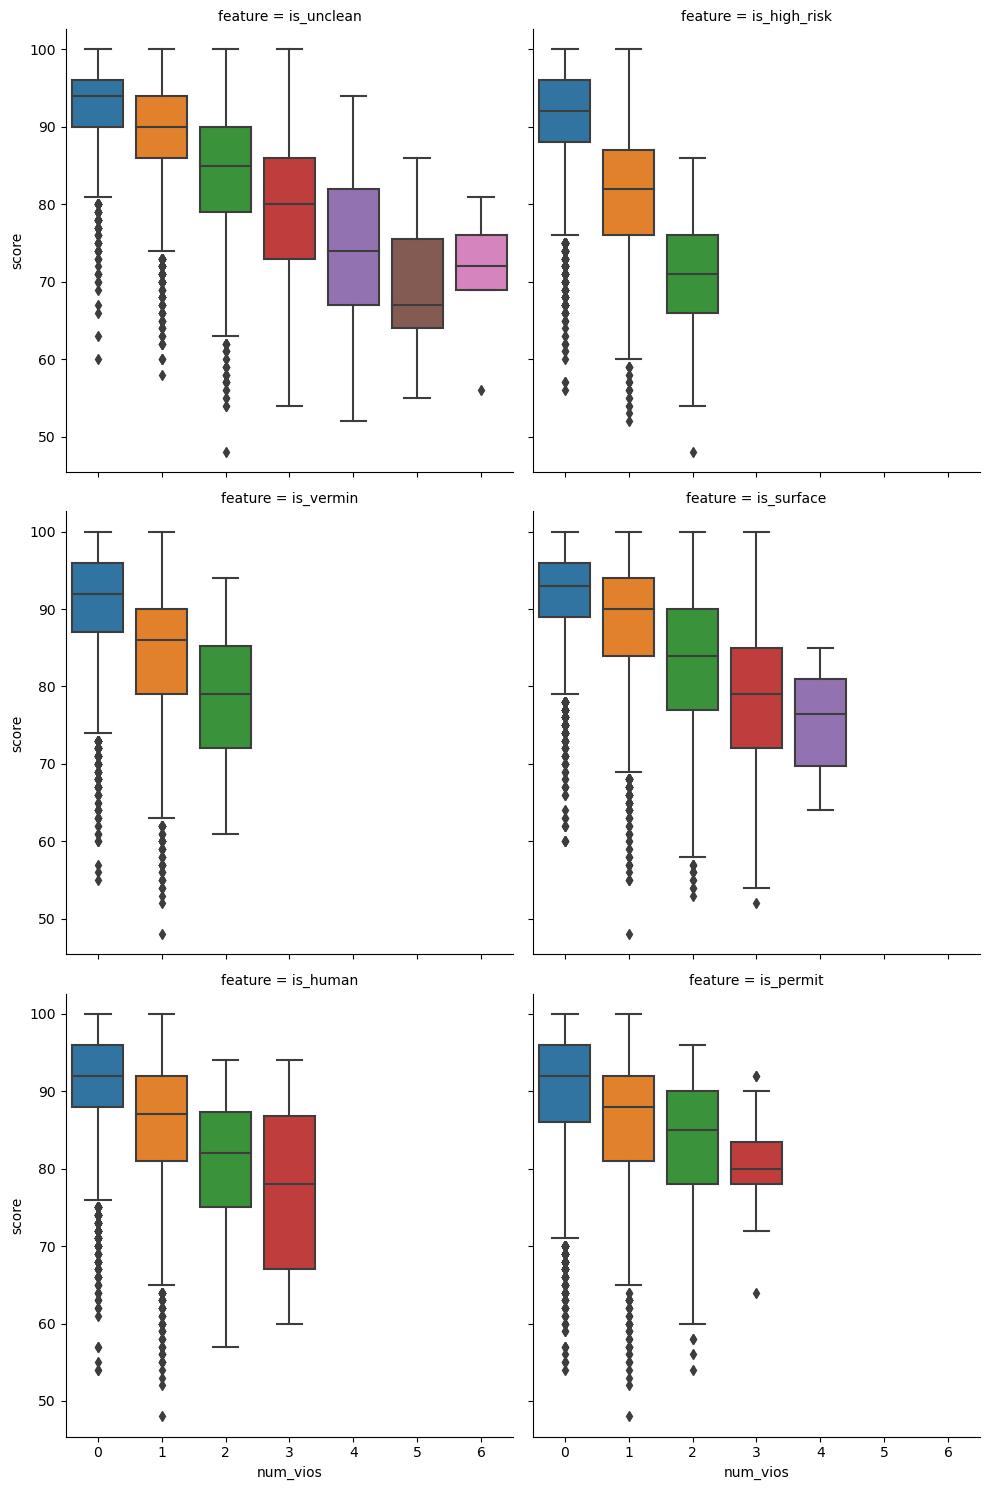

In [95]:
# you will learn this syntax next week. Focus on interpreting for now.
sns.catplot(x='num_vios', y='score',
               col='feature', col_wrap=2,
               kind='box',
               data=violation_type_and_scores);

Above we can observe:
* The inspection score generally goes down with increasing numbers of violations, as expected.
* Depending on the violation keyword, inspections scores on average go down at slightly different rates.
* For example, that if a restaurant inspection involved 2 violations with the keyword "vermin", the average score for that inspection would be a little bit below 80.

## Bonus Content: Using pd.to_datetime to Extract Time Information

Date parsing using `pd.to_datetime`.

In [48]:
pd.Series(log_lines).str.extract(r'\[(.*) -0800\]').apply(
    lambda s: pd.to_datetime(s, format='%d/%b/%Y:%H:%M:%S'))

,0
0,2014-01-26 10:47:58
1,2005-02-02 17:23:06
2,2006-02-03 10:18:37
